In [2]:
import cv2
import pandas as pd
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
face_cascade = cv2.CascadeClassifier('../Data/haarcascade_frontalface_default.xml')

In [4]:
def load_and_detect_faces(folder_path):
    images = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Detect face
                    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                    for (x, y, w, h) in faces:
                        face_region = img[y:y+h, x:x+w] # Crop to face region
                        images.append(face_region)
                        labels.append(label)
    return images, labels

In [5]:
# Define parameters for LBP
radius = 1
n_points = 8 * radius

# Function to extract LBP features from the cropped face images
def extract_lbp_features(images):
    lbp_features = []
    for img in images:
        # Resize face image to a standard size if needed
        img = cv2.resize(img, (64, 64)) # Standard size
        lbp = local_binary_pattern(img, n_points, radius, method='uniform')
        # Histogram of LBP patterns
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        # Normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        lbp_features.append(hist)
    return np.array(lbp_features)

In [ ]:
def extract_hog_features(images):
    hog_features = []
    # Define HOG parameters
    # Play around with these values later, but these are good starting points:
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)
    orientations = 8 # Number of orientation bins

    for img in images:
        # 1. Resize/Convert: Ensure consistent size (64x64) and proper type (float)
        img = cv2.resize(img, (64, 64))

        # 2. Compute HOG: output_vector=True returns a single flattened vector
        features = hog(
            img,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm='L2-Hys', # Standard normalization scheme
            transform_sqrt=True, # Improves performance
            feature_vector=True
        )
        hog_features.append(features)

    return np.array(hog_features)

In [7]:
jaffe_folder_path = "../Data/assignment/jaffe"

jaffe_images, jaffe_labels = load_and_detect_faces(jaffe_folder_path)

# jaffe_lbp_features = extract_lbp_features(jaffe_images)
jaffe_hog_features = extract_hog_features(jaffe_images)

# x_train, x_test, y_train, y_test = train_test_split(jaffe_lbp_features, jaffe_labels, test_size=0.2, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(jaffe_hog_features, jaffe_labels, test_size=0.2, random_state=42)

In [11]:
tree_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)

tree_classifier.fit(x_train, y_train)

y_pred = tree_classifier.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 27.03%
[[0 1 0 3 3 0]
 [1 3 0 2 1 1]
 [0 0 2 3 0 0]
 [0 0 0 2 0 4]
 [0 0 1 1 2 1]
 [0 0 1 3 1 1]]


In [ ]:
def predict_emotion_hog(image_path, model):
    # Load the image in color
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found or could not be loaded.")

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # If no faces are detected, return
    if len(faces) == 0:
        print("No faces detected in the image.")
        return

    # Assume first detected face (for single face case)
    (x, y, w, h) = faces[0]
    face_region = img[y:y+h, x:x+w]

    # Extract HOG features from the detected face region
    features, hog_image = extract_hog_features(face_region)

    # Reshape features for model input
    features = features.reshape(1, -1)

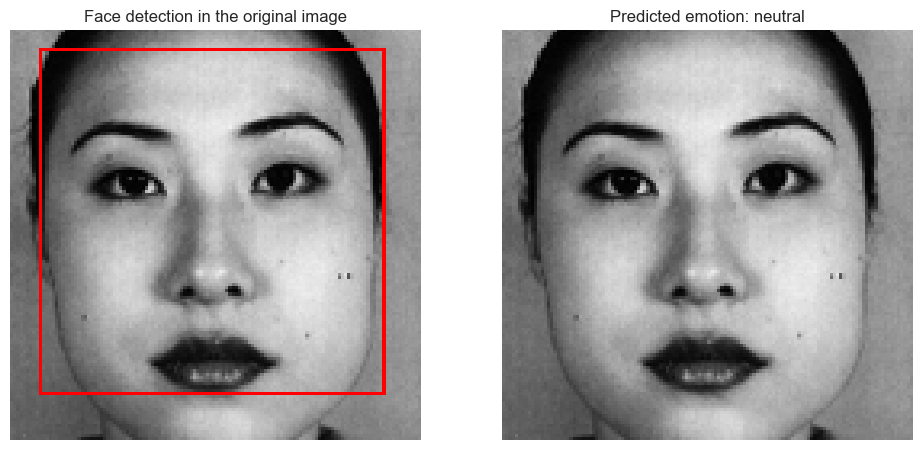

In [15]:
# Function to predict and display the expression of a single image
def predict_emotion(image_path, model):
    # Load the image in color
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found or could not be loaded.")

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # If no faces are detected, return
    if len(faces) == 0:
        print("No faces detected in the image.")
        return

    # Loop over the detected faces
    for (x, y, w, h) in faces:
        face_region = img[y:y+h, x:x+w] # Crop the detected face region
        face_region = cv2.resize(face_region, (64, 64))
        lbp = local_binary_pattern(face_region, n_points, radius, method='uniform')

        # Histogram of LBP patterns
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)

        # Predict expression
        features = hist.reshape(1, -1)
        prediction = model.predict(features)[0]

        img_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

        # Draw rectangle
        img_with_box = img_rgb.copy()
        cv2.rectangle(img_with_box, (x, y), (x + w, y + h), (255, 0, 0), 1)

        plt.figure(figsize = (18, 6))

        # Display the image with prediction label

        plt.subplot(1, 3, 1)
        plt.imshow(img_with_box)
        plt.title(f"Face detection in the original image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(img_rgb)
        plt.title(f"Predicted emotion: {prediction}")
        plt.axis('off')

        plt.show()


image_path = "./testimages/24.tiff"
predict_emotion(image_path, tree_classifier)